In [1]:
#code from https://www.kaggle.com/likith012/ecgnet-ptb-xl/notebook
#data from https://www.kaggle.com/khyeh0719/ptb-xl-dataset-wrangling/data?select=ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1
import numpy as np
import pandas as pd
import wfdb
import ast
import glob
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
#from keras.regularizers import l2
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from scipy.signal import spectrogram
from sklearn.model_selection import train_test_split
import math
#import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,normalize
#import keras
#import tensorflow.keras.backend as K
#print(tf.test.gpu_device_name())
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
#K.tensorflow_backend._get_available_gpus()

#import keras
#model = keras.models.load_model('MyModel')
#print(model.summary())
#tf.disable_v2_behavior()
#config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1} )
#sess = tf.Session(config=config)
#keras.backend.set_session(sess)
## Preprocessing
#   Using the super classes, multi label classification, excluding samples with no labels and considering atleast one label

#path = '../input/ptbxl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'
#path = '/Volumes/Industry Data/ECG_DATA/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'
#path = '/Users/fatima/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'
path = 'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'

Y = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')

data = np.array([wfdb.rdsamp(path + f)[0] for f in Y.filename_lr])
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

agg_df = pd.read_csv(path + 'scp_statements.csv', index_col=0)

agg_df = agg_df[agg_df.diagnostic == 1]


def agg(y_dic):
    temp = []

    for key in y_dic.keys():
        if key in agg_df.index:
            c = agg_df.loc[key].diagnostic_class
            if str(c) != 'nan':
                temp.append(c)
    return list(set(temp))


Y['diagnostic_superclass'] = Y.scp_codes.apply(agg)
Y['superdiagnostic_len'] = Y['diagnostic_superclass'].apply(lambda x: len(x))




In [2]:
counts = pd.Series(np.concatenate(Y.diagnostic_superclass.values)).value_counts()

Y['diagnostic_superclass'] = Y['diagnostic_superclass'].apply(
    lambda x: list(set(x).intersection(set(counts.index.values))))

X_data = data[Y['superdiagnostic_len'] == 1]
Y_data = Y[Y['superdiagnostic_len'] == 1]

mlb = MultiLabelBinarizer()
mlb.fit(Y_data['diagnostic_superclass'])
y = mlb.transform(Y_data['diagnostic_superclass'].values)
#from numpy import asarray
#from numpy import savetxt
# define data
#data = asarray([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
# save to csv file
##savetxt('data.csv', X_data, delimiter=',')
##savetxt('y_ptbxl.csv', Y_data, delimiter=',')
# load numpy array from csv file
##from numpy import loadtxt
# load array
##X_data = loadtxt('data.csv', delimiter=',')
##Y_data=loadtxt('y_ptbxl.csv', delimiter=',')
########
#y= y_train
## Stratify split
flag=0
X_train = X_data[Y_data.strat_fold < 9]
y_train = y[Y_data.strat_fold < 9]

X_val = X_data[Y_data.strat_fold == 9]
y_val = y[Y_data.strat_fold == 9]

X_test = X_data[Y_data.strat_fold == 10]
y_test = y[Y_data.strat_fold == 10]

In [3]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
#from tensorflow import keras
from torch import nn
from torch.utils.data import DataLoader , TensorDataset
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import copy
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
from torchinfo import summary

from datetime import datetime
#from tensorflow.keras import regularizers
#from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import torch
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn
import itertools
import pywt
NUM_FEATURES = 12
# For complex phase included, number of features doubles
# NUM_FEATURES = 232*2

#SEQ_LENGTH = 1000#from shape the number of coloumns

# TODO must not hardcode
# BATCH_SIZE = 32
BATCH_SIZE = 256
LEARNING_RATE = 0.001
EPOCHS = 1000

encoder = preprocessing.LabelEncoder()

NUM_CLASSES = -1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def data2tensor(X, y, encoder):
    """convert rawdata and rawlabel with encoder to pytorch tensor

    Keyword arguments:
    rawdata -- np array of rawdata
    rawlabels -- np array of labels corresponding to rawdata
    encoder -- instance of LabelEncoder used for encoding

    Returns:
    tensor: torch.Tensor of type DoubleTensor with
            dimension [batch size (i.e. number of X instances), NUM_FEATURES, SEQ_LENGTH]
    """
    # labels as digit representation instead of letters
    
    encoder.fit(y)
    y = encoder.transform(y)
    #print('ANOTHER TEST')
    tensors = []
    labels = []
    for i in range(len(y)):
        #if X[i].shape == (NUM_FEATURES, SEQ_LENGTH):  # skip data with incorrect dimensions TODO: avoid hardcoding
            # r_tensor = torch.tensor(rawdata[i].real, device=device)
            # i_tensor = torch.tensor(rawdata[i].imag, device=device)
            # tensors.append(torch.cat((r_tensor, i_tensor), 0))

            # append the absolute value (TODO should be configurable)

            # ts_fft = sp.fftpack.fft(rawdata[i])
            # ts_psd = np.abs(ts_fft) ** 2
            # tensors.append(torch.tensor(ts_psd, device=device))
        tensors.append(torch.tensor(np.absolute(X[i]), device=device))
        labels.append(y[i])
    #tensors=np.array(tensors)
    #tensors=tensors.reshape(tensors.shape[0],12,1000)
    return torch.stack(tensors), torch.as_tensor(labels, device=device)

#rawdata, rawlabels = load_dataset(csi_data)
print('ANOTHER TEST')
if(flag==1):
    X_train=X_train.cpu().numpy()
    y_train=y_train.cpu().numpy()
    X_val=X_val.cpu().numpy()
    y_val=y_val.cpu().numpy()
    X_test=X_test.cpu().numpy()
    y_test=y_test.cpu().numpy()
    
#data=np.array(data)
#print(data.shape)
#expanding dimensions to make it 3-D
print('Before')
#data=data.expand_dims(data,1)
yy=np.argmax(y_train, axis=1)
print(np.unique(yy))
weights = sklearn.utils.class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(yy), y=np.array(yy) )
#weights = [0.1, 1.0]
sc=torch.tensor(weights).float().to(device)

#data=np.expand_dims(data,1)
#print(data.shape)
#y_train=y_train.argmax(-1)
X_train= torch.tensor(X_train)
y_train= torch.tensor(y_train)
#y_val=y_val.argmax(-1)
X_val= torch.tensor(X_val)
y_val= torch.tensor(y_val)
#y_test=y_test.argmax(-1)
X_test= torch.tensor(X_test)
y_test= torch.tensor(y_test)
print(X_train.shape)
print(y_train.shape)

if(flag==0):
    flag=1
    y_train=np.argmax(y_train, axis=1)
    y_val=np.argmax(y_val, axis=1)
    y_test=np.argmax(y_test, axis=1)
    

X_train, y_train = data2tensor(X_train, y_train, encoder)
X_val, y_val = data2tensor(X_val, y_val, encoder)
X_test, y_test = data2tensor(X_test, y_test, encoder)


print(X_train.shape)
print(y_train.shape)


#mean = torch.mean(data)
#std = torch.std(data)

from torchvision import transforms
#normalize = transforms.Normalize(mean, std)
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
#nor_data = normalize(data).to(device)
#data=np.expand_dims(data,1)
print('before trasform')
print(X_train.shape)
print("data.shape")
#X_train = dim_embedding(X_train)
#X_test = dim_embedding(X_test)
#X_val = dim_embedding(X_val)
print("data.shape after")
print(X_train.shape)
#mean = torch.mean(data)
#std = torch.std(data)






ANOTHER TEST
Before
[0 1 2 3 4]
torch.Size([12978, 1000, 12])
torch.Size([12978, 5])


/home/test/conda/envs/torch-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([12978, 1000, 12])
torch.Size([12978])
before trasform
torch.Size([12978, 1000, 12])
data.shape
data.shape after
torch.Size([12978, 1000, 12])


In [4]:
##X_train=torch.reshape(X_train, (X_train.shape[1],X_train.shape[2],X_train.shape[0]))

#X_val=torch.reshape(X_val, (X_val.shape[1],X_val.shape[0],X_val.shape[2]))
##X_val=torch.reshape(X_val, (X_val.shape[1],X_val.shape[2],X_val.shape[0]))
##X_test=torch.reshape(X_test, (X_test.shape[1],X_test.shape[2],X_test.shape[0]))
print('ANOTHER TEST')
NUM_CLASSES = len(encoder.classes_)
print(NUM_CLASSES)
# split data into training, validation, and test (todo: make better configurable)

train_dataset=TensorDataset(X_train, y_train)
val_dataset=TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)
dataloader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator())
dataloader_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator())
dataloader_test = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator())

ANOTHER TEST
5


In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve, auc
from sklearn.preprocessing import label_binarize
import sklearn.metrics as metrics

!nvidia-smi
NUM_FEATURES = X_train.shape[2]#X_train.shape[1]#12
# For complex phase included, number of features doubles
# NUM_FEATURES = 232*2
BATCH_SIZE = 100#256
SEQ_LENGTH = X_train.shape[1]#X_train.shape[2]#from shape the number of coloumns
EPOCHS=1000#1000
LEARNING_RATE = 0.00025#0.00015#from 0.001

#####
class CNN(nn.Module):
    def __init__(self, hidden):
        super(CNN, self).__init__()

        self.hiddenLast=hidden
        self.hidden1=64#64
        self.hidden2=64#128
        self.hidden3=64
        self.hidden4=64

        self.kernel_size=5
        
        self.activation=nn.LeakyReLU(0.1)

        self.first=True
        
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=12, out_channels=self.hidden1, kernel_size=self.kernel_size),
            nn.BatchNorm1d(num_features=self.hidden1),
            self.activation,
            #nn.MaxPool1d(kernel_size=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=self.hidden1, out_channels=self.hidden2, kernel_size=self.kernel_size),
            nn.BatchNorm1d(num_features=self.hidden2),
            self.activation,
            #nn.MaxPool1d(kernel_size=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=self.hidden2, out_channels=self.hidden3, kernel_size=self.kernel_size),
            nn.BatchNorm1d(num_features=self.hidden3),
            self.activation,
            nn.MaxPool1d(kernel_size=2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=self.hidden3, out_channels=self.hidden4, kernel_size=self.kernel_size),
            nn.BatchNorm1d(num_features=self.hidden4),
            self.activation,
            nn.MaxPool1d(kernel_size=2)
        )

        self.convLast = nn.Sequential(
            nn.Conv1d(in_channels=self.hidden4, out_channels=self.hiddenLast, kernel_size=self.kernel_size),
            nn.BatchNorm1d(num_features=self.hiddenLast),
            self.activation,
            nn.Dropout(0.05),
            nn.MaxPool1d(kernel_size=2)
        )


    def forward(self, x):
        #print('SHAPE AFTER',x.shape)
        x = self.conv1(x)
        #print('SHAPE AFTER',x.shape)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.convLast(x)
        if self.first:
            #print(x.size())
            self.first=False
        return x

class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()

        self.cnn_output = 128
        # Depends on number of CNN layers, how often Max Pooling is used etc.
        self.seq_length_after_cnn = 120#98#58#53#248
        #1998
        self.hidden_lstm = 128

        self.cnn = CNN(hidden=self.cnn_output)

        self.lstm = nn.LSTM(input_size=self.cnn_output, hidden_size=self.hidden_lstm, batch_first=True, num_layers=4)
        #self.lstm = nn.LSTM(input_size=self.hidden_lstm, hidden_size=self.hidden_lstm, batch_first=True, num_layers=10)
        #self.lstm = nn.LSTM(input_size=self.cnn_output, hidden_size=self.hidden_lstm, batch_first=True, num_layers=50)
        #self.lstm = nn.LSTM(input_size=self.cnn_output, hidden_size=self.hidden_lstm, batch_first=True, num_layers=50)

        self.fc = nn.Linear(in_features=self.hidden_lstm*self.seq_length_after_cnn, out_features=5)


    def forward(self, x):
        # 3d: batch size, features (1), seq length (4000)
        ##print('SHAPE',x.shape)
        x = x.permute(0, 2, 1)
        x = self.cnn(x)
        print('AFTER CNN',x.shape)
        # 3d: batch size, features (self.hidden_cnn), seq length after cnn
        x = x.permute(0, 2, 1)
        ##print('AFTER PE')
        # 3d: batch size, seq length, features
        x, (h_n, c_n) = self.lstm(x)
        #x, (h_n, c_n) = self.lstm(x)
        ##print('AFTER LSTM',x.shape)
        # 3d: batch size, seq length, features
        x = x.reshape(-1, self.hidden_lstm*self.seq_length_after_cnn)
        ##print('AFTER RESHAPE')
        # 2d: batch size, (features*seq length)
        x = self.fc(x)
        return x

    

Mon Apr 18 22:40:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:01:00.0 Off |                    0 |
| N/A   26C    P0    37W / 250W |  21831MiB / 40536MiB |      3%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-PCI...  Off  | 00000000:C1:00.0 Off |                    0 |
| N/A   

In [6]:
model = CNN_LSTM().to(device)

loss_fn = nn.CrossEntropyLoss()
#loss_fn = loss_fn = nn.CrossEntropyLoss(weight=sc, reduction='mean', label_smoothing=0.01)#nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [7]:
val_losses = []
train_losses = []
def train_loop(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    log_step = 10

    for batch, (X, y) in enumerate(dataloader):
        pred = model(X.float())
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % log_step == 0:
          loss, current = loss.item(), batch * len(X)
          print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss /= num_batches
    train_losses.append(train_loss)
    # For loss graph on tensorboard
    writer.add_scalar('Loss/Train', train_loss, epoch)


def validation_loop(dataloader, model, loss_fn, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    validation_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.float())
            validation_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    validation_loss /= num_batches
    val_losses.append(validation_loss)
    correct /= size
    # For loss graph on tensorboard
    writer.add_scalar('Loss/Validation', validation_loss, epoch)
    print(f"Accuracy: {(100*correct):>0.2f}%, Avg loss: {validation_loss:>8f}")
    return (correct, validation_loss)

In [8]:
from datetime import datetime

%xmode Verbose

loss_of_best_accuracy = float('inf')
best_accuracy = 0
best_model = None
best_epoch = 0
print(summary(model))
start_time = datetime.now()
for t in range(EPOCHS):
    print(f"\nEpoch {t+1}\n-------------------------------")
    train_loop(dataloader_train, model, loss_fn, optimizer, t+1)
    accuracy, loss = validation_loop(dataloader_val, model, loss_fn, t+1)
    if accuracy > best_accuracy or (accuracy == best_accuracy and loss < loss_of_best_accuracy):
        best_accuracy = accuracy
        loss_of_best_accuracy = loss
        best_model = copy.deepcopy(model)
        best_epoch = t+1
        print('Model saved')
end_time = datetime.now()
print(f"\nDone! Validation accuracy: {(100*best_accuracy):>0.2f}%")
print(f"Training took {(end_time-start_time).total_seconds():>0.2f} seconds")



Exception reporting mode: Verbose
Layer (type:depth-idx)                   Param #
CNN_LSTM                                 --
├─CNN: 1-1                               --
│    └─LeakyReLU: 2-1                    --
│    └─Sequential: 2-2                   --
│    │    └─Conv1d: 3-1                  3,904
│    │    └─BatchNorm1d: 3-2             128
│    │    └─LeakyReLU: 3-3               --
│    └─Sequential: 2-3                   --
│    │    └─Conv1d: 3-4                  20,544
│    │    └─BatchNorm1d: 3-5             128
│    │    └─LeakyReLU: 3-6               --
│    └─Sequential: 2-4                   --
│    │    └─Conv1d: 3-7                  20,544
│    │    └─BatchNorm1d: 3-8             128
│    │    └─LeakyReLU: 3-9               --
│    │    └─MaxPool1d: 3-10              --
│    └─Sequential: 2-5                   --
│    │    └─Conv1d: 3-11                 20,544
│    │    └─BatchNorm1d: 3-12            128
│    │    └─LeakyReLU: 3-13              --
│    │    └─MaxPoo

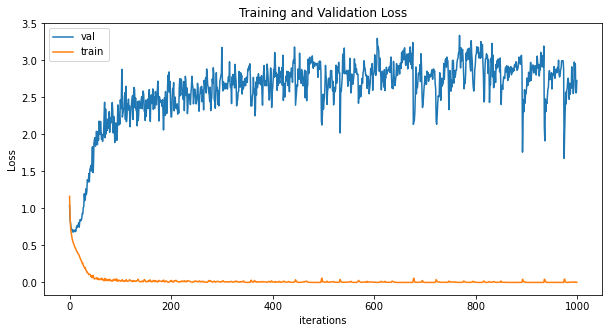

In [9]:
# Plot simple loss graph, see also tensorboard
import matplotlib.pyplot as plt


plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Layer (type:depth-idx)                   Param #
CNN_LSTM                                 --
├─CNN: 1-1                               --
│    └─LeakyReLU: 2-1                    --
│    └─Sequential: 2-2                   --
│    │    └─Conv1d: 3-1                  3,904
│    │    └─BatchNorm1d: 3-2             128
│    │    └─LeakyReLU: 3-3               --
│    └─Sequential: 2-3                   --
│    │    └─Conv1d: 3-4                  20,544
│    │    └─BatchNorm1d: 3-5             128
│    │    └─LeakyReLU: 3-6               --
│    └─Sequential: 2-4                   --
│    │    └─Conv1d: 3-7                  20,544
│    │    └─BatchNorm1d: 3-8             128
│    │    └─LeakyReLU: 3-9               --
│    │    └─MaxPool1d: 3-10              --
│    └─Sequential: 2-5                   --
│    │    └─Conv1d: 3-11                 20,544
│    │    └─BatchNorm1d: 3-12            128
│    │    └─LeakyReLU: 3-13              --
│    │    └─MaxPool1d: 3-14              --
│    └─S

/home/test/conda/envs/torch-gpu/lib/python3.7/site-packages/torch/nn/modules/rnn.py:692: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/cudnn/RNN.cpp:925.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


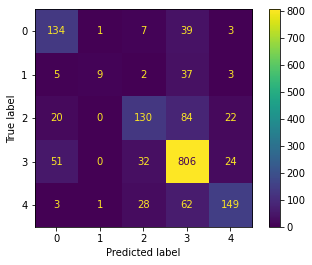

In [10]:
print(summary(model))
@torch.no_grad()
def predict(model, loader):
    # initialise empty tensors for predictions and targets
    all_preds = torch.tensor([], device=device, dtype=int)
    all_targets = torch.tensor([], device=device, dtype=int)
    model.eval()
    for batch in loader:
        data, labels = batch
        preds = model(data.float()).argmax(1)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
        all_targets = torch.cat((all_targets, labels.int()), dim=0)
    model.train()    
    return all_preds, all_targets
with torch.no_grad():
  predictions, targets = predict(best_model, dataloader_test)
#for x,y in enumerate(predictions):
 #   print(y,targets[x])
print(predictions,targets)
print('###################')
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve, auc
from sklearn.preprocessing import label_binarize
cm = confusion_matrix(targets.cpu(), predictions.cpu())
accuracy_score(predictions.cpu(), targets.cpu())
print('testing',accuracy_score(predictions.cpu(), targets.cpu()))
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

#roc = {label: [] for label in targets.unique()}
roc = {label: [] for label in targets}

#print(targets.unique())
#######

y = label_binarize(targets.cpu(), classes=[0, 1, 2,3,4])
y_predictions = label_binarize(predictions.cpu(), classes=[0, 1, 2,3,4])
#print(y,y_predictions)
n_classes = y.shape[1]
score_sk = roc_auc_score(y, y_predictions)
print('BEOFRE',score_sk)
#print(tf.py_func(roc_auc_score, (y, y_predictions), tf.double))

print(n_classes)
#print(y.shape)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[i], y_predictions[i])
    print(fpr[i], tpr[i])
    print('_________')
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(i,roc_auc[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print('MICRO',roc_auc["micro"])
#all_fpr = torch.from_numpy(np.unique(np.concatenate([fpr[i] for i in range(y.unique())])))
# First aggregate all false positive rates
# code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
print('ROC',roc_auc["macro"])


In [179]:
def evaluate_experiment(y_true, y_pred, thresholds=None):
    results = {}

    if not thresholds is None:
        # binary predictions
        y_pred_binary = apply_thresholds(y_pred, thresholds)
        # PhysioNet/CinC Challenges metrics
        challenge_scores = challenge_metrics(y_true, y_pred_binary, beta1=2, beta2=2)
        results['F_beta_macro'] = challenge_scores['F_beta_macro']
        results['G_beta_macro'] = challenge_scores['G_beta_macro']

    # label based metric
    #print(accuracy(y_true, y_pred))
    results['macro_auc'] = roc_auc_score(y_true, y_pred, average='macro')
    print( results['macro_auc'])
    #print(metric.accuracy(y_true, y_pred))
evaluate_experiment(y,y_predictions,None)  





0.7653313644244817


In [133]:
len(y_train)



12978

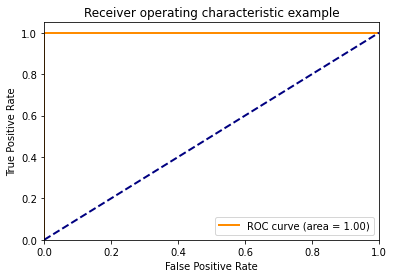

In [180]:
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

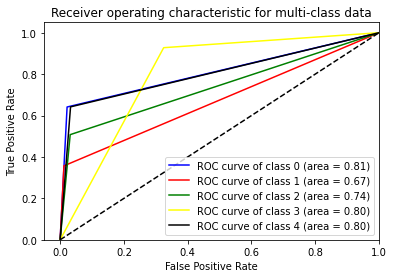

In [181]:
from itertools import cycle
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','yellow','black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()